In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.ar_model import AR,ARResults
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from helperfxns import *
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import itertools
%load_ext autoreload
%autoreload 2

In [2]:
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

In [3]:
w_df = pd.read_csv('weather_clean.csv', index_col=0)

In [20]:
w_df.tail()

,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
DATE,,,,,,,,,,,,,,,,,,,
2019-10-29,6.49,0.16,0.0,0.0,57.0,60,55,60,80,12.1,14.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-30,5.59,0.15,0.0,0.0,60.0,65,58,10,30,10.1,13.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-10-31,11.86,0.59,0.0,0.0,67.0,74,62,200,270,28.0,42.9,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-01,14.54,0.02,0.0,0.0,57.0,62,43,280,290,28.0,44.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2019-11-02,6.49,0.00,0.0,0.0,46.0,53,36,280,270,12.1,16.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
w_df['is_holiday'] = np.where(w_df.index.isin(holidays), 1, 0)

In [6]:
w_df.drop(w_df.head(13).index,inplace=True)

In [7]:
df = pd.read_csv('put_sales.csv', index_col=0)

In [8]:
sdf = df.drop(['day_of_week'], axis=1)

In [93]:
sdf.head()

,net_sales
2017-03-14,5120.50
2017-03-15,4105.00
2017-03-16,6941.00
2017-03-17,15053.39
2017-03-18,11338.50


In [17]:
df.shape

(964, 3)

In [18]:
w_df.shape

(964, 19)

In [9]:
bdf = pd.concat([df, w_df], axis=1)

In [10]:
bdf.index = pd.to_datetime(bdf.index)

In [11]:
bdf.head()

,net_sales,day_of_week,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,...,WSF2,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09
DATE,,,,,,,,,,,,,,,,,,,,,
2017-03-14,5120.50,Tuesday,22.59,1.15,6.9,3.9,30.0,32,22,10,...,38.0,47.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2017-03-15,4105.00,Wednesday,19.24,0.00,0.0,5.1,24.0,27,20,270,...,31.1,40.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-16,6941.00,Thursday,15.21,0.00,0.0,5.1,30.0,41,23,290,...,25.9,33.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-17,15053.39,Friday,10.74,0.00,0.0,3.9,36.0,47,26,260,...,19.9,25.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-03-18,11338.50,Saturday,9.17,0.05,0.0,3.1,36.0,39,28,40,...,19.9,25.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


I'd like to add holidays as an exog bool

In [12]:
cal = calendar()
holidays = cal.holidays(start=bdf.index.min(), end=bdf.index.max())

In [14]:
bdf['is_holiday'] = np.where(bdf.index.isin(holidays), 1, 0)

In [209]:
bdf.sample(20)

,net_sales,day_of_week,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,...,WT03,WT04,WT05,WT06,WT08,WT09,natural_log,first_difference,seasonal_difference,is_holiday
DATE,,,,,,,,,,,,,,,,,,,,,
2019-06-28,7470.74,Friday,6.49,0.00,0.0,0.0,83.0,90,71,200,...,0.0,0.0,0.0,0.0,0.0,0.0,8.918749,2076.19,-2051.39,0
2019-02-13,4424.21,Wednesday,15.21,0.06,0.0,1.2,36.0,42,33,280,...,0.0,0.0,0.0,0.0,0.0,0.0,8.394847,2185.19,503.90,0
2018-10-09,3660.70,Tuesday,4.70,0.00,0.0,0.0,70.0,78,65,260,...,0.0,0.0,0.0,0.0,0.0,0.0,8.205410,-239.68,457.02,0
2018-12-03,4317.00,Monday,12.97,0.00,0.0,0.0,53.0,55,45,260,...,0.0,0.0,0.0,0.0,0.0,0.0,8.370316,-2284.60,-777.13,0
2017-05-29,7673.33,Monday,6.71,0.14,0.0,0.0,60.0,61,57,90,...,0.0,0.0,0.0,0.0,0.0,0.0,8.945506,-3310.76,4102.83,1
2018-02-02,8662.10,Friday,18.34,0.14,0.0,0.0,33.0,41,17,310,...,0.0,0.0,0.0,0.0,0.0,0.0,9.066712,3956.42,638.41,0
2019-08-04,6640.92,Sunday,6.26,0.50,0.0,0.0,79.0,91,70,360,...,1.0,0.0,0.0,0.0,0.0,0.0,8.801006,-1724.22,-1260.12,0
2018-11-13,2810.93,Tuesday,12.30,0.90,0.0,0.0,46.0,50,43,320,...,0.0,0.0,0.0,0.0,0.0,0.0,7.941271,-217.29,-1649.62,0
2017-10-17,5586.68,Tuesday,7.38,0.00,0.0,0.0,51.0,62,40,200,...,0.0,0.0,0.0,0.0,0.0,0.0,8.628140,2183.38,2883.73,0


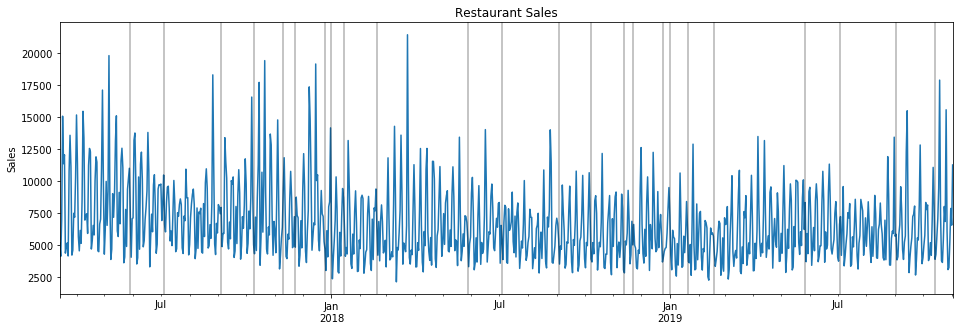

In [11]:
title='Restaurant Sales'
ylabel='Sales'
xlabel='' # we don't really need a label here

ax = bdf['net_sales'].plot(figsize=(16,5),title=title)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in bdf.query('is_holiday==1').index:       # for days where holiday == 1
    ax.axvline(x=x, color='k', alpha = 0.3);  # add a semi-transparent grey line

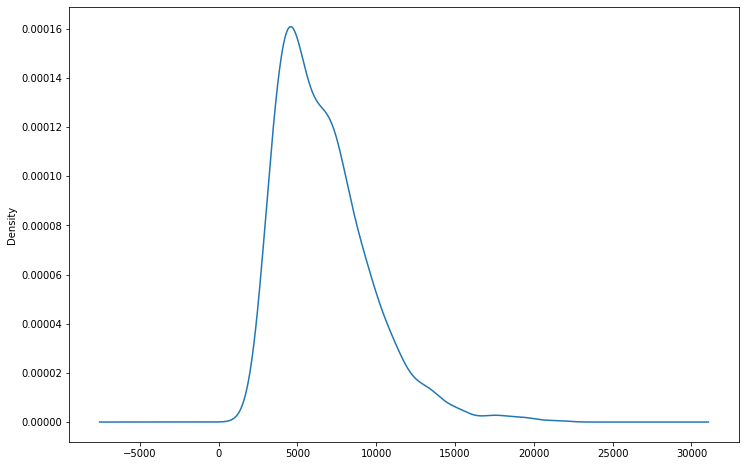

In [34]:
bdf['net_sales'].plot.kde(figsize=(12,8));

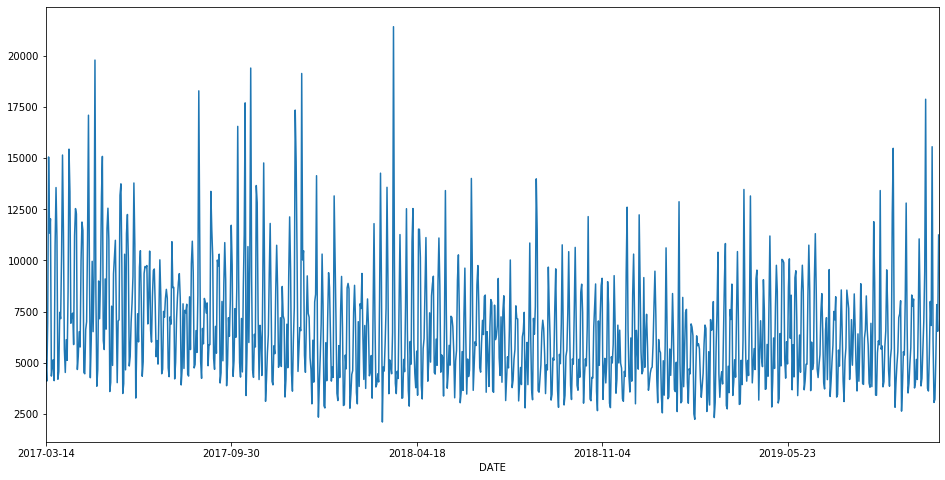

In [32]:
bdf['net_sales'].plot(figsize=(16,8));

<Figure size 432x288 with 0 Axes>

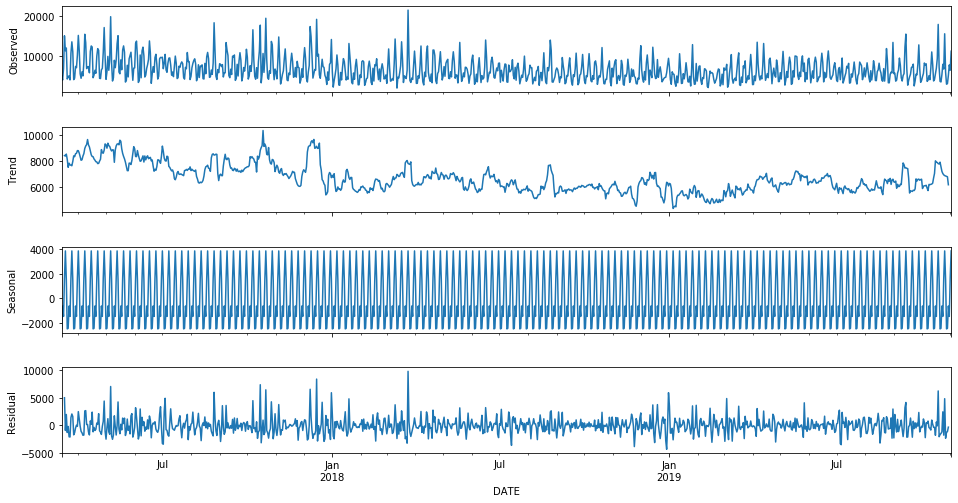

In [187]:
decomposition = seasonal_decompose(bdf['net_sales'], freq=7)
fig = plt.figure()
fig = decomposition.plot()
fig.set_size_inches(15, 8);

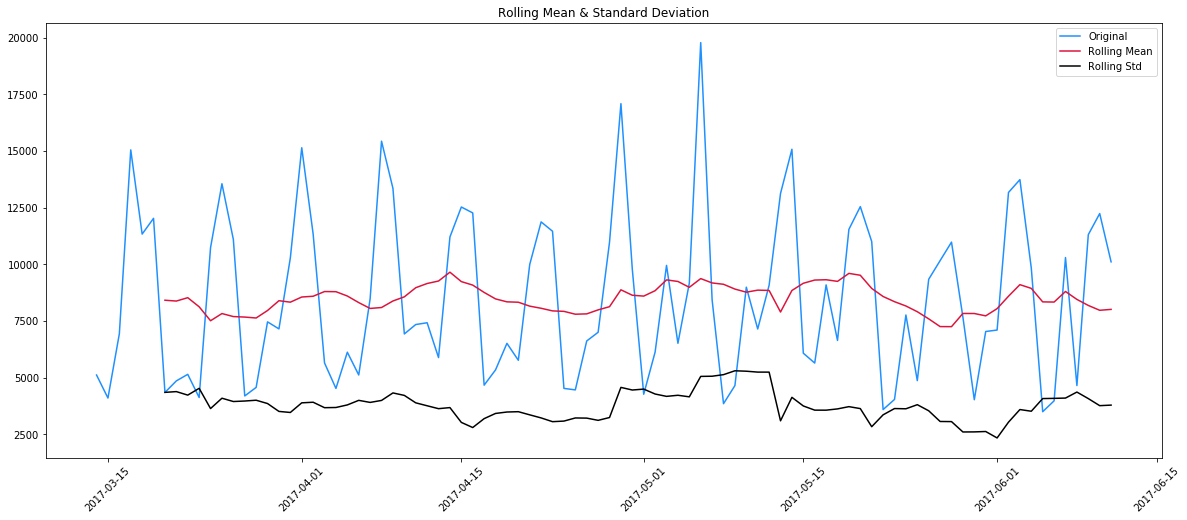

Results of Dickey-Fuller Test:
Test Statistic                 -3.164506
p-value                         0.022133
#Lags Used                     12.000000
Number of Observations Used    77.000000
Critical Value (1%)            -3.518281
Critical Value (5%)            -2.899878
Critical Value (10%)           -2.587223
dtype: float64


In [188]:
alt_test_stationarity(bdf['net_sales'][:90], 7)

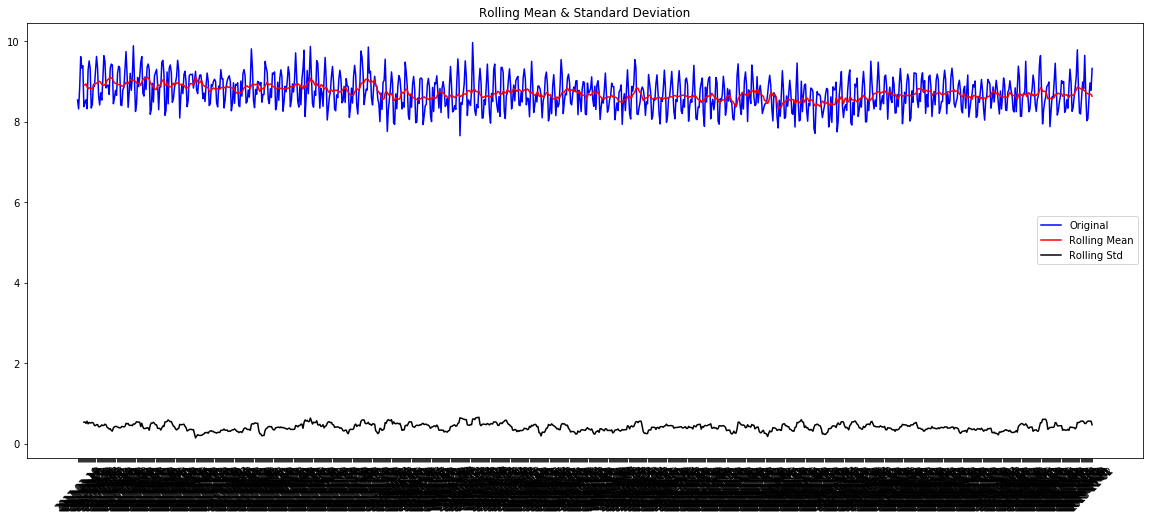

Results of Dickey-Fuller Test:
Test Statistic                  -2.721598
p-value                          0.070375
#Lags Used                      20.000000
Number of Observations Used    943.000000
Critical Value (1%)             -3.437304
Critical Value (5%)             -2.864610
Critical Value (10%)            -2.568405
dtype: float64


In [54]:
#exploring log transformation as an option
bdf['natural_log'] = bdf.net_sales.apply(lambda x: np.log(x))  
alt_test_stationarity(bdf.natural_log, 7)

#### well that made it worse..

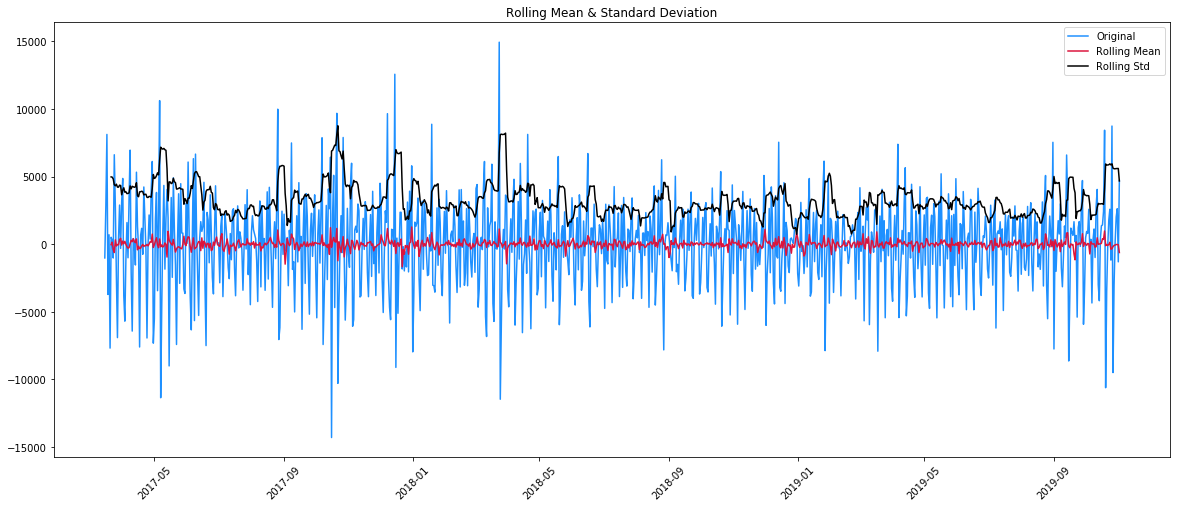

Results of Dickey-Fuller Test:
Test Statistic                -1.130823e+01
p-value                        1.257697e-20
#Lags Used                     1.900000e+01
Number of Observations Used    9.430000e+02
Critical Value (1%)           -3.437304e+00
Critical Value (5%)           -2.864610e+00
Critical Value (10%)          -2.568405e+00
dtype: float64


In [189]:
# first difference
bdf['first_difference'] = bdf.net_sales - bdf.net_sales.shift(1)
alt_test_stationarity(bdf.first_difference.dropna(), 7)

## much better!

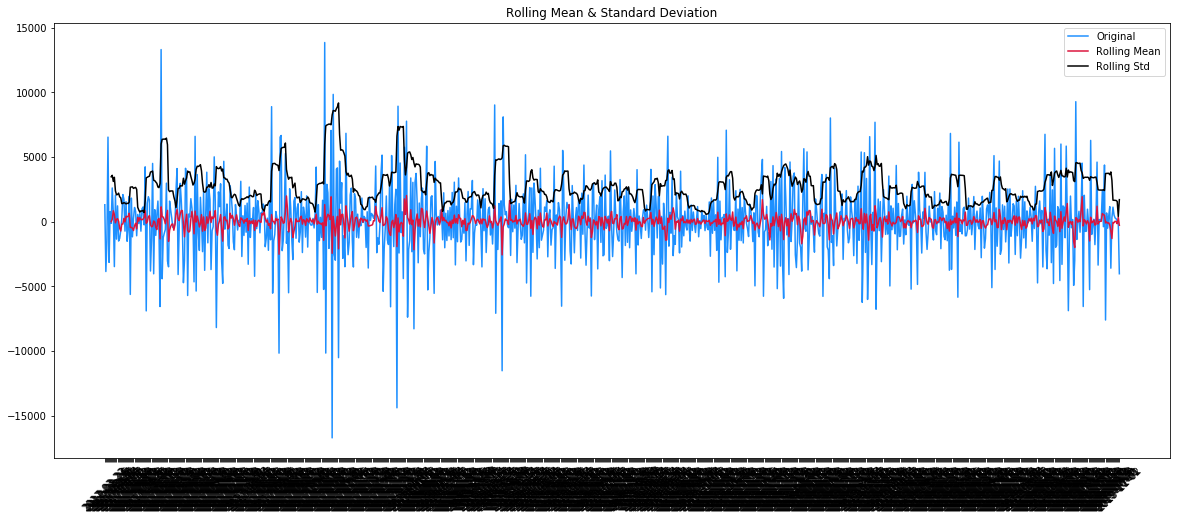

Results of Dickey-Fuller Test:
Test Statistic                -1.086159e+01
p-value                        1.441772e-19
#Lags Used                     2.200000e+01
Number of Observations Used    9.330000e+02
Critical Value (1%)           -3.437378e+00
Critical Value (5%)           -2.864643e+00
Critical Value (10%)          -2.568422e+00
dtype: float64


In [115]:
# a look at seasonal difference (7 days)
bdf['seasonal_difference'] = bdf.first_difference - bdf.first_difference.shift(7)
alt_test_stationarity(bdf.seasonal_difference.dropna(), 7)

# Moving forward with first difference.

In [119]:
bdf.head(20)

,net_sales,day_of_week,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,...,WT02,WT03,WT04,WT05,WT06,WT08,WT09,natural_log,first_difference,seasonal_difference
DATE,,,,,,,,,,,,,,,,,,,,,
2017-03-14,5120.50,Tuesday,22.59,1.15,6.9,3.9,30.0,32,22,10,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,8.541007,NaN,NaN
2017-03-15,4105.00,Wednesday,19.24,0.00,0.0,5.1,24.0,27,20,270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.319961,-1015.50,NaN
2017-03-16,6941.00,Thursday,15.21,0.00,0.0,5.1,30.0,41,23,290,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.845201,2836.00,NaN
2017-03-17,15053.39,Friday,10.74,0.00,0.0,3.9,36.0,47,26,260,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.619358,8112.39,NaN
2017-03-18,11338.50,Saturday,9.17,0.05,0.0,3.1,36.0,39,28,40,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.335959,-3714.89,NaN
2017-03-19,12033.31,Sunday,13.42,0.00,0.0,3.1,39.0,48,33,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.395434,694.81,NaN
2017-03-20,4352.21,Monday,10.51,0.00,0.0,1.2,43.0,55,34,360,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.378439,-7681.10,NaN
2017-03-21,4861.96,Tuesday,6.93,0.00,0.0,0.0,50.0,62,42,270,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.489197,509.75,NaN
2017-03-22,5150.45,Wednesday,19.46,0.00,0.0,0.0,42.0,49,24,340,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.546839,288.49,1303.99


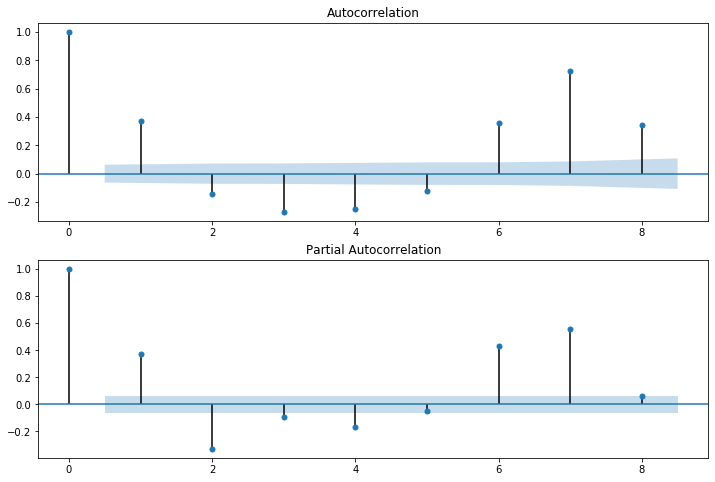

In [12]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(bdf.net_sales, lags=8, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(bdf.net_sales, lags=8, ax=ax2)

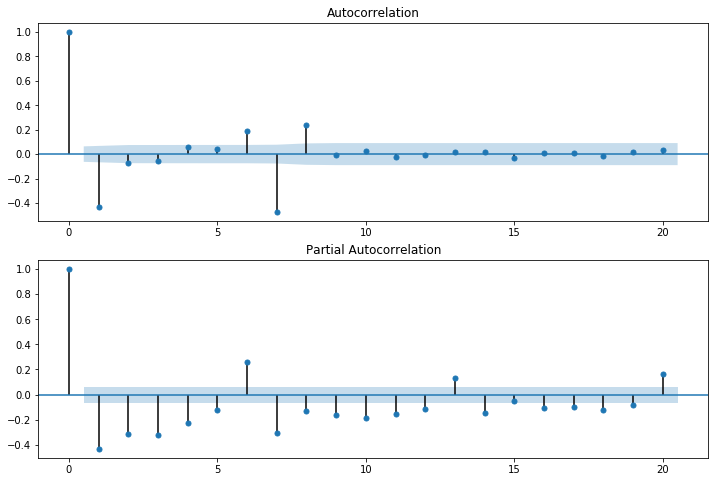

In [191]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
#plot the ACF
fig = sm.graphics.tsa.plot_acf(bdf.seasonal_difference.iloc[8:], lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
#plot the PACF
fig = sm.graphics.tsa.plot_pacf(bdf.seasonal_difference.iloc[8:], lags=20, ax=ax2)

In [71]:
bdf.corr()

,net_sales,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,WDF5,...,WT02,WT03,WT04,WT05,WT06,WT08,WT09,natural_log,first_difference,seasonal_difference
net_sales,1.000000,-0.005004,-0.054059,-0.027397,0.005815,0.049945,0.064895,0.025862,0.024074,0.028079,...,-0.040836,-0.034663,-0.077707,-0.010263,-0.087666,-0.072132,-0.022897,0.965326,0.560868,0.358570
AWND,-0.005004,1.000000,0.055974,0.138592,0.154873,-0.236196,-0.252468,-0.268079,0.294248,0.252897,...,-0.014258,-0.074555,0.091061,0.055977,0.022525,-0.106591,0.162065,-0.004876,0.050684,0.015820
PRCP,-0.054059,0.055974,1.000000,0.164937,-0.016161,0.020373,-0.012494,0.060075,-0.124412,-0.128019,...,0.120024,0.334038,0.136557,0.021236,0.087300,0.014952,0.093109,-0.042392,-0.029549,-0.101622
SNOW,-0.027397,0.138592,0.164937,1.000000,0.185071,-0.179494,-0.191078,-0.165488,-0.035675,0.013141,...,0.147043,0.022798,0.304836,0.162897,0.232868,-0.022632,0.582678,-0.032452,-0.003471,0.020468
SNWD,0.005815,0.154873,-0.016161,0.185071,1.000000,-0.268145,-0.262435,-0.255125,0.046687,0.094999,...,0.017455,-0.037548,0.175532,0.023194,0.111158,-0.008895,0.120700,-0.001388,-0.002541,-0.019226
TAVG,0.049945,-0.236196,0.020373,-0.179494,-0.268145,1.000000,0.978262,0.980142,-0.087726,-0.098867,...,-0.063241,0.295686,-0.179484,-0.073028,-0.136208,0.002686,-0.081067,0.090409,-0.001771,0.004186
TMAX,0.064895,-0.252468,-0.012494,-0.191078,-0.262435,0.978262,1.000000,0.943516,-0.049322,-0.051766,...,-0.054806,0.289137,-0.179888,-0.077365,-0.126392,0.019761,-0.089155,0.104460,0.006881,0.015372
TMIN,0.025862,-0.268079,0.060075,-0.165488,-0.255125,0.980142,0.943516,1.000000,-0.129255,-0.148953,...,-0.066304,0.314351,-0.168567,-0.072701,-0.123483,0.010516,-0.080752,0.064885,-0.008833,-0.004838
WDF2,0.024074,0.294248,-0.124412,-0.035675,0.046687,-0.087726,-0.049322,-0.129255,1.000000,0.803522,...,-0.015718,0.009038,-0.044508,-0.001621,-0.025185,0.011884,-0.024624,0.022364,0.113756,0.040860
WDF5,0.028079,0.252897,-0.128019,0.013141,0.094999,-0.098867,-0.051766,-0.148953,0.803522,1.000000,...,-0.011663,0.014280,-0.010247,0.058701,-0.034218,0.009440,0.028103,0.027462,0.112188,0.070750


In [61]:
auto_arima(bdf['net_sales'].dropna())

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(2, 1, 3),
      out_of_sample_size=0, scoring='mse', scoring_args=None,
      seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
      suppress_warnings=False, transparams=True, trend=None,
      with_intercept=True)

In [82]:
model = sm.tsa.statespace.SARIMAX(bdf['net_sales'],order=(2, 1, 3), seasonal_order=(0, 0, 0, 1), scoring='mse', solver='lbfgs')

In [83]:
results = model.fit()
print(results.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2461      0.002    539.602      0.000       1.242       1.251
ar.L2         -0.9995      0.001  -1207.448      0.000      -1.001      -0.998
ma.L1         -2.2051      0.022   -101.520      0.000      -2.248      -2.163
ma.L2          2.1531      0.034     63.498      0.000       2.087       2.220
ma.L3         -0.9235      0.020    -45.529      0.000      -0.963      -0.884
sigma2       6.46e+06   3.43e-10   1.88e+16      0.000    6.46e+06    6.46e+06


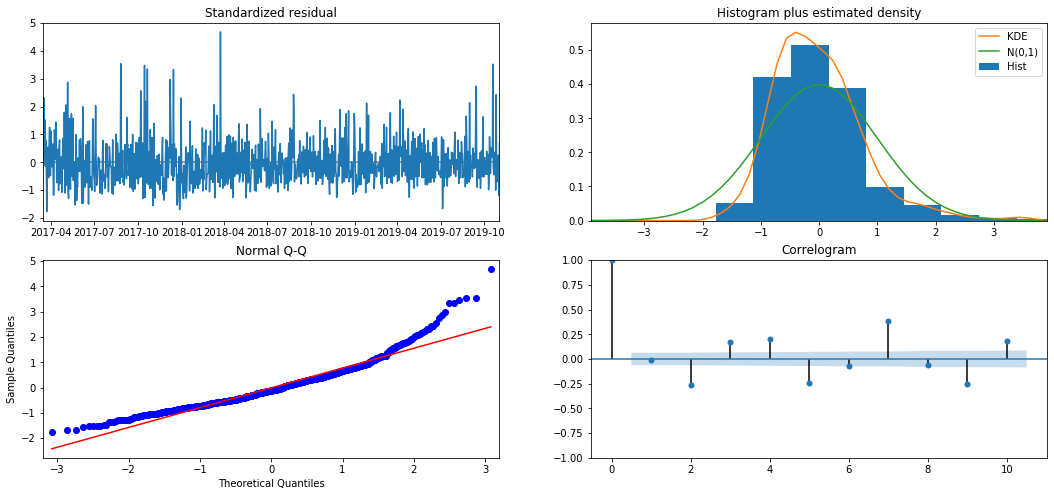

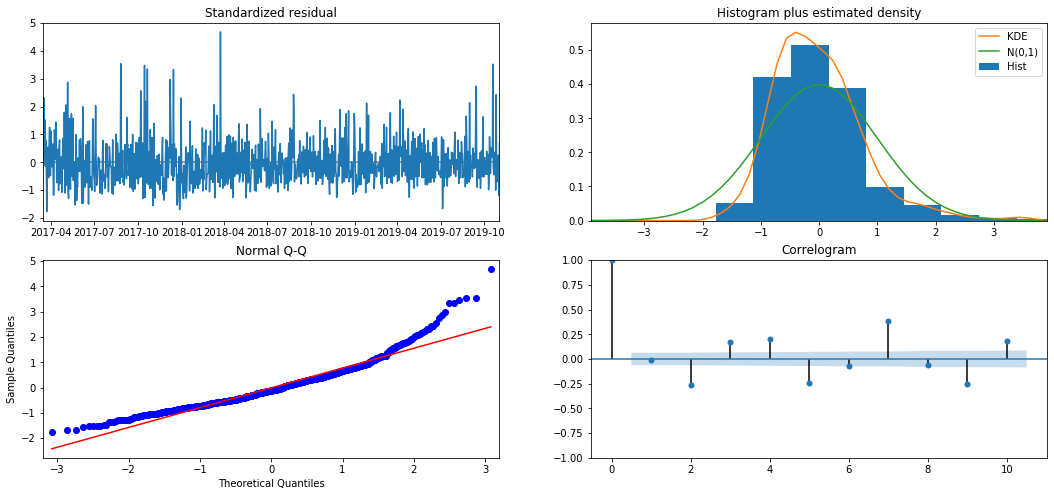

In [84]:
results.plot_diagnostics(figsize=(18, 8))

In [62]:
auto_arima(bdf['net_sales'],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  964
Model:             SARIMAX(4, 1, 2)x(2, 0, 1, 7)   Log Likelihood               -8528.723
Date:                           Wed, 13 Nov 2019   AIC                          17079.445
Time:                                   14:35:35   BIC                          17133.016
Sample:                                        0   HQIC                         17099.843
                                           - 964                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -0.0022      0.036     -0.061      0.952      -0.073       0.068
ar.L1         -0.8889      0.037    -24.106      0.000      -0.961      -0.817
ar.L2          0.0504      0.057      0.882      0.378      -0.062       0.163
ar.L3         -0.0933      0.063     -1.479      0.139      -0.217       0.030
ar.L4         -0.0348      0.045     -0.769      0.442      -0.123       0.054
ma.L1          0.0195      0.036      0.536      0.592      -0.052       0.091
ma.L2         -0.9802      0.037    -26.848      0.000      -1.052      -0.909
ar.S.L7        1.1565      0.030     38.563      0.000       1.098       1.215
ar.S.L14      -0.1575      0.030     -5.285      0.000      -0.216      -0.099
ma.S.L7       -0.9575      0.017    -56.297      0.000      -0.991      -0.924
sigma2      3.548e+06   1.52e-08   2.33e+14      0.000    3.55e+06    3.55e+06
===================================================================================
Ljung-Box (Q):                       27.36   Jarque-Bera (JB):              1523.03
Prob(Q):                              0.94   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             1.45
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 6.81e+28. Standard errors may be unstable.
"""

In [125]:
bdf.tail(14)

,net_sales,day_of_week,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,...,WT02,WT03,WT04,WT05,WT06,WT08,WT09,natural_log,first_difference,seasonal_difference
DATE,,,,,,,,,,,,,,,,,,,,,
2019-10-20,7263.08,Sunday,3.80,0.66,0.0,0.0,52.0,58,44,60,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.890559,-10609.88,-7607.78
2019-10-21,3754.00,Monday,5.59,0.00,0.0,0.0,57.0,69,49,20,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.230577,-3509.08,670.61
2019-10-22,3623.57,Tuesday,8.95,0.51,0.0,0.0,59.0,64,53,100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.195215,-130.43,-501.85
2019-10-23,5415.26,Wednesday,9.62,0.01,0.0,0.0,62.0,68,50,310,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.596976,1791.69,431.20
2019-10-24,7997.08,Thursday,5.59,0.00,0.0,0.0,56.0,69,45,230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.986832,2581.82,1160.65
2019-10-25,6822.39,Friday,4.70,0.00,0.0,0.0,NaN,67,46,230,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.827965,-1174.69,-3600.46
2019-10-26,15554.16,Saturday,6.49,0.01,0.0,0.0,NaN,63,50,10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.652083,8731.77,308.19
2019-10-27,6063.13,Sunday,10.07,1.38,0.0,0.0,NaN,70,57,120,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.709981,-9491.03,1118.85
2019-10-28,3063.93,Monday,6.93,0.01,0.0,0.0,60.0,63,55,330,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.027454,-2999.20,509.88


In [126]:
len(bdf)

964

In [139]:
train = bdf.iloc[:950]
test = bdf.iloc[950:]

In [211]:
model = SARIMAX(train['net_sales'],order=(4,1,2),seasonal_order=(2,0,1,7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         net_sales   No. Observations:                  950
Model:             SARIMAX(4, 1, 2)x(2, 0, 1, 7)   Log Likelihood               -8405.732
Date:                           Tue, 12 Nov 2019   AIC                          16831.464
Time:                                   16:09:42   BIC                          16880.018
Sample:                               03-14-2017   HQIC                         16849.965
                                    - 10-19-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0302      1.393      0.022      0.983      -2.700       2.761
ar.L2         -0.0558      0.194     -0.288      0.773      -0.436       0.324
ar.L3         -0.0271      0.114     -0.238      0.812      -0.250       0.196
ar.L4          0.0318      0.057      0.559      0.576      -0.080       0.143
ma.L1         -0.8819      1.393     -0.633      0.527      -3.612       1.849
ma.L2         -0.1016      1.374     -0.074      0.941      -2.795       2.591
ar.S.L7        1.1168      0.031     36.546      0.000       1.057       1.177
ar.S.L14      -0.1193      0.030     -3.955      0.000      -0.178      -0.060
ma.S.L7       -0.9329      0.020    -45.793      0.000      -0.973      -0.893
sigma2      3.547e+06   6.63e-06   5.35e+11      0.000    3.55e+06    3.55e+06
===================================================================================
Ljung-Box (Q):                       27.97   Jarque-Bera (JB):              1680.41
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             1.53
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 8.74e+26. Standard errors may be unstable.
"""

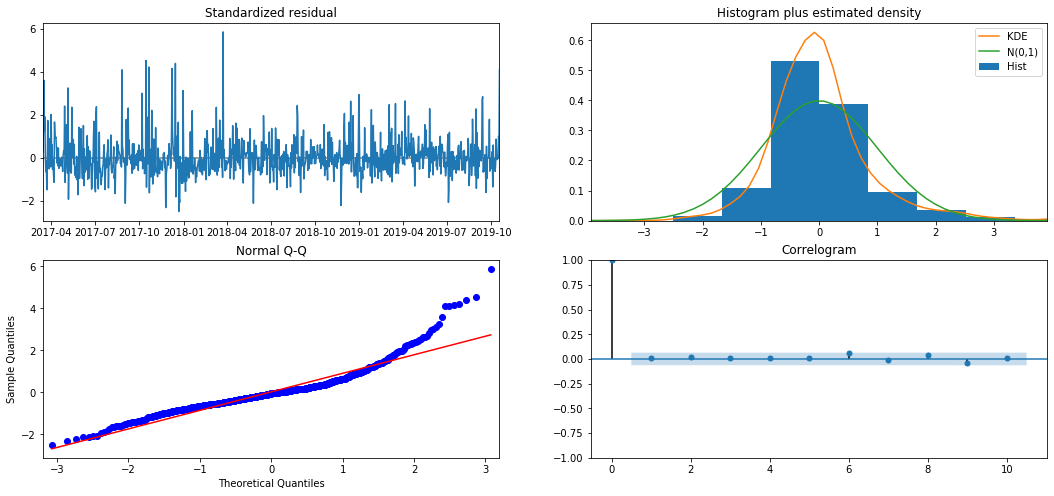

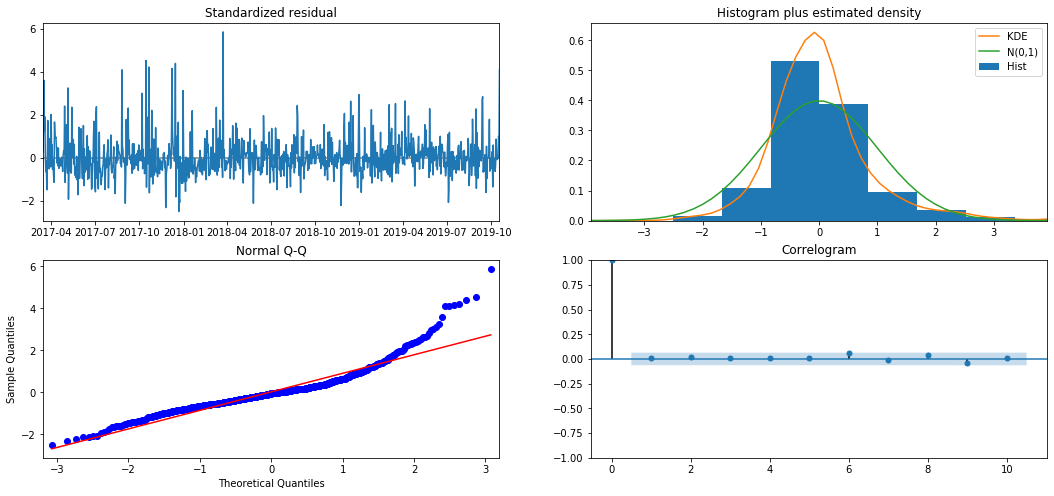

In [212]:
results.plot_diagnostics(figsize=(18, 8))

In [213]:
# Obtain predicted values
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=True, typ='levels').rename('SARIMA Predictions')

In [214]:
pred = results.get_prediction(start=start, end=end, dynamic=True)
pred_ci = pred.conf_int()

In [215]:
for i in range(len(predictions)):
    print(f"predicted={predictions[i]:<11.10}, expected={test['net_sales'][i]}")

predicted=8676.086471, expected=7263.08
predicted=3900.074121, expected=3754.0
predicted=4162.101327, expected=3623.57
predicted=6079.710998, expected=5415.26
predicted=5849.768135, expected=7997.08
predicted=8122.64884 , expected=6822.39
predicted=11432.84174, expected=15554.16
predicted=7955.658247, expected=6063.13
predicted=4304.636886, expected=3063.93
predicted=4378.584109, expected=3216.01
predicted=5933.260714, expected=5224.46
predicted=5676.304503, expected=7843.98
predicted=7996.365652, expected=6539.28
predicted=10686.66419, expected=11242.04


In [216]:
test['net_sales']

DATE
2019-10-20     7263.08
2019-10-21     3754.00
2019-10-22     3623.57
2019-10-23     5415.26
2019-10-24     7997.08
2019-10-25     6822.39
2019-10-26    15554.16
2019-10-27     6063.13
2019-10-28     3063.93
2019-10-29     3216.01
2019-10-30     5224.46
2019-10-31     7843.98
2019-11-01     6539.28
2019-11-02    11242.04
Name: net_sales, dtype: float64

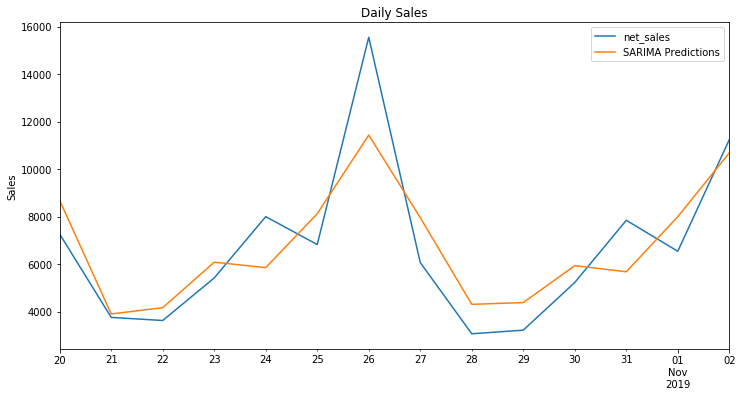

In [219]:
title = 'Daily Sales'
ylabel='Sales'
xlabel=''

ax = test['net_sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

In [220]:
error = mean_squared_error(test['net_sales'], predictions)
print(f'SARIMA MSE Error: {error}')

SARIMA MSE Error: 2867262.376613731


In [221]:
error = rmse(test['net_sales'], predictions)
print(f'SARIMA RMSE Error: {error}')

SARIMA RMSE Error: 1693.299257843613


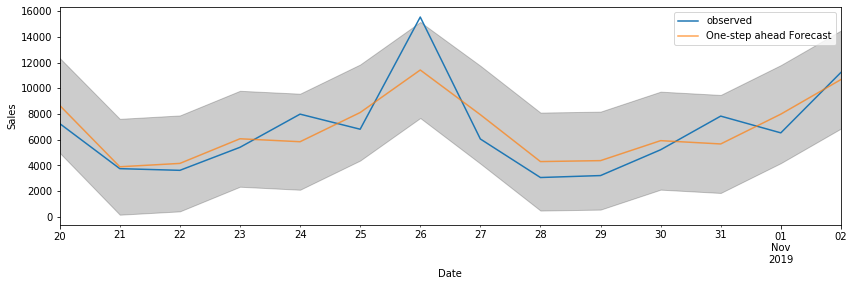

In [183]:
ax = test['net_sales'].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 4))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Sales')
plt.legend()
plt.show()

Trying a different method of picking the paramaters

In [93]:
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 7) for x in list(itertools.product(p, d, q))]

In [94]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(bdf['net_sales'],order=param, 
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 7)12 - AIC:19862.221253004776
ARIMA(0, 0, 0)x(0, 0, 1, 7)12 - AIC:19144.945545985065
ARIMA(0, 0, 0)x(0, 0, 2, 7)12 - AIC:18238.901364312253
ARIMA(0, 0, 0)x(0, 1, 0, 7)12 - AIC:17356.10430721564
ARIMA(0, 0, 0)x(0, 1, 1, 7)12 - AIC:16850.631462323337
ARIMA(0, 0, 0)x(0, 1, 2, 7)12 - AIC:16690.57476960025
ARIMA(0, 0, 0)x(0, 2, 0, 7)12 - AIC:18244.676416216404
ARIMA(0, 0, 0)x(0, 2, 1, 7)12 - AIC:17170.718107686946
ARIMA(0, 0, 0)x(0, 2, 2, 7)12 - AIC:16764.352644296174
ARIMA(0, 0, 0)x(1, 0, 0, 7)12 - AIC:17351.87571096138
ARIMA(0, 0, 0)x(1, 0, 1, 7)12 - AIC:17029.659737764818
ARIMA(0, 0, 0)x(1, 0, 2, 7)12 - AIC:16849.61248710115
ARIMA(0, 0, 0)x(1, 1, 0, 7)12 - AIC:17025.76846209794
ARIMA(0, 0, 0)x(1, 1, 1, 7)12 - AIC:16841.68810933343
ARIMA(0, 0, 0)x(1, 1, 2, 7)12 - AIC:16676.851717723242
ARIMA(0, 0, 0)x(1, 2, 0, 7)12 - AIC:17589.24133727605
ARIMA(0, 0, 0)x(1, 2, 1, 7)12 - AIC:16997.80142871996
ARIMA(0, 0, 0)x(1, 2, 2, 7)12 - AIC:16729.718894013997
ARIMA(0, 0, 0)x(2,

ARIMA(0, 1, 2)x(1, 2, 1, 7)12 - AIC:16877.011419902552
ARIMA(0, 1, 2)x(1, 2, 2, 7)12 - AIC:17352.578955087567
ARIMA(0, 1, 2)x(2, 0, 0, 7)12 - AIC:17096.602255485057
ARIMA(0, 1, 2)x(2, 0, 1, 7)12 - AIC:17018.764700558328
ARIMA(0, 1, 2)x(2, 0, 2, 7)12 - AIC:16966.098330693432
ARIMA(0, 1, 2)x(2, 1, 0, 7)12 - AIC:16912.311394050914
ARIMA(0, 1, 2)x(2, 1, 1, 7)12 - AIC:16646.66442921669
ARIMA(0, 1, 2)x(2, 1, 2, 7)12 - AIC:16613.469890437984
ARIMA(0, 1, 2)x(2, 2, 0, 7)12 - AIC:17242.197136079623
ARIMA(0, 1, 2)x(2, 2, 1, 7)12 - AIC:16744.98919538284
ARIMA(0, 1, 2)x(2, 2, 2, 7)12 - AIC:17294.682353934084
ARIMA(0, 2, 0)x(0, 0, 0, 7)12 - AIC:19019.969044821333
ARIMA(0, 2, 0)x(0, 0, 1, 7)12 - AIC:18734.82264681396
ARIMA(0, 2, 0)x(0, 0, 2, 7)12 - AIC:18533.535408257107
ARIMA(0, 2, 0)x(0, 1, 0, 7)12 - AIC:18911.693907642322
ARIMA(0, 2, 0)x(0, 1, 1, 7)12 - AIC:18355.998248005217
ARIMA(0, 2, 0)x(0, 1, 2, 7)12 - AIC:18217.45745631177
ARIMA(0, 2, 0)x(0, 2, 0, 7)12 - AIC:19803.30997866764
ARIMA(0, 2, 0)x

ARIMA(1, 0, 2)x(0, 1, 2, 7)12 - AIC:16715.40791532791
ARIMA(1, 0, 2)x(0, 2, 0, 7)12 - AIC:18120.1382426152
ARIMA(1, 0, 2)x(0, 2, 1, 7)12 - AIC:17129.49177855146
ARIMA(1, 0, 2)x(0, 2, 2, 7)12 - AIC:17246.435156070693
ARIMA(1, 0, 2)x(1, 0, 0, 7)12 - AIC:17400.73328593894
ARIMA(1, 0, 2)x(1, 0, 1, 7)12 - AIC:16892.786190919836
ARIMA(1, 0, 2)x(1, 0, 2, 7)12 - AIC:16896.154303392083
ARIMA(1, 0, 2)x(1, 1, 0, 7)12 - AIC:17029.132032211466
ARIMA(1, 0, 2)x(1, 1, 1, 7)12 - AIC:16750.530071147972
ARIMA(1, 0, 2)x(1, 1, 2, 7)12 - AIC:16714.17403457326
ARIMA(1, 0, 2)x(1, 2, 0, 7)12 - AIC:17673.947539761015
ARIMA(1, 0, 2)x(1, 2, 1, 7)12 - AIC:17361.861670402235
ARIMA(1, 0, 2)x(1, 2, 2, 7)12 - AIC:17203.14428780291
ARIMA(1, 0, 2)x(2, 0, 0, 7)12 - AIC:17227.476208398624
ARIMA(1, 0, 2)x(2, 0, 1, 7)12 - AIC:17150.871395674665
ARIMA(1, 0, 2)x(2, 0, 2, 7)12 - AIC:17116.138207903543
ARIMA(1, 0, 2)x(2, 1, 0, 7)12 - AIC:16816.730324972104
ARIMA(1, 0, 2)x(2, 1, 1, 7)12 - AIC:16748.539739933614
ARIMA(1, 0, 2)x(2

ARIMA(1, 2, 1)x(2, 0, 2, 7)12 - AIC:17660.98513323125
ARIMA(1, 2, 1)x(2, 1, 0, 7)12 - AIC:17171.14613001592
ARIMA(1, 2, 1)x(2, 1, 1, 7)12 - AIC:17255.948877076404
ARIMA(1, 2, 1)x(2, 1, 2, 7)12 - AIC:17233.929942888528
ARIMA(1, 2, 1)x(2, 2, 0, 7)12 - AIC:18025.16502654632
ARIMA(1, 2, 1)x(2, 2, 1, 7)12 - AIC:17914.059872410664
ARIMA(1, 2, 1)x(2, 2, 2, 7)12 - AIC:17885.437835393124
ARIMA(1, 2, 2)x(0, 0, 0, 7)12 - AIC:18252.87842312442
ARIMA(1, 2, 2)x(0, 0, 1, 7)12 - AIC:17908.54036917995
ARIMA(1, 2, 2)x(0, 0, 2, 7)12 - AIC:17489.97006607624
ARIMA(1, 2, 2)x(0, 1, 0, 7)12 - AIC:17353.945891866315
ARIMA(1, 2, 2)x(0, 1, 1, 7)12 - AIC:16944.03997854543
ARIMA(1, 2, 2)x(0, 1, 2, 7)12 - AIC:16811.127461857046
ARIMA(1, 2, 2)x(0, 2, 0, 7)12 - AIC:18202.860948531
ARIMA(1, 2, 2)x(0, 2, 1, 7)12 - AIC:17513.61579412609
ARIMA(1, 2, 2)x(0, 2, 2, 7)12 - AIC:17284.080894313083
ARIMA(1, 2, 2)x(1, 0, 0, 7)12 - AIC:17617.37297475779
ARIMA(1, 2, 2)x(1, 0, 1, 7)12 - AIC:17505.411814971776
ARIMA(1, 2, 2)x(1, 0, 

ARIMA(2, 1, 1)x(1, 0, 0, 7)12 - AIC:17163.135010103382
ARIMA(2, 1, 1)x(1, 0, 1, 7)12 - AIC:17351.7640804774
ARIMA(2, 1, 1)x(1, 0, 2, 7)12 - AIC:16763.984620837207
ARIMA(2, 1, 1)x(1, 1, 0, 7)12 - AIC:17056.461327294972
ARIMA(2, 1, 1)x(1, 1, 1, 7)12 - AIC:16738.09185048804
ARIMA(2, 1, 1)x(1, 1, 2, 7)12 - AIC:16614.155567332557
ARIMA(2, 1, 1)x(1, 2, 0, 7)12 - AIC:17765.266591423373
ARIMA(2, 1, 1)x(1, 2, 1, 7)12 - AIC:17269.190358787455
ARIMA(2, 1, 1)x(1, 2, 2, 7)12 - AIC:17167.25230693804
ARIMA(2, 1, 1)x(2, 0, 0, 7)12 - AIC:16911.72767290725
ARIMA(2, 1, 1)x(2, 0, 1, 7)12 - AIC:17215.443512457652
ARIMA(2, 1, 1)x(2, 0, 2, 7)12 - AIC:17216.431652752784
ARIMA(2, 1, 1)x(2, 1, 0, 7)12 - AIC:16891.996997354097
ARIMA(2, 1, 1)x(2, 1, 1, 7)12 - AIC:16632.778490275145
ARIMA(2, 1, 1)x(2, 1, 2, 7)12 - AIC:16774.315524217458
ARIMA(2, 1, 1)x(2, 2, 0, 7)12 - AIC:17549.34793615186
ARIMA(2, 1, 1)x(2, 2, 1, 7)12 - AIC:16712.150609047254
ARIMA(2, 1, 1)x(2, 2, 2, 7)12 - AIC:17402.43061736899
ARIMA(2, 1, 2)x(0

In [106]:
model = SARIMAX(train['net_sales'],order=(0,0,2),seasonal_order=(1,1,3,7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         net_sales   No. Observations:                  950
Model:             SARIMAX(0, 0, 2)x(1, 1, 3, 7)   Log Likelihood               -8353.248
Date:                           Wed, 13 Nov 2019   AIC                          16720.497
Time:                                   15:44:48   BIC                          16754.440
Sample:                               03-14-2017   HQIC                         16733.434
                                    - 10-19-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1656      0.029      5.720      0.000       0.109       0.222
ma.L2         -0.0011      0.037     -0.030      0.976      -0.073       0.071
ar.S.L7        0.9910      0.076     12.966      0.000       0.841       1.141
ma.S.L7       -1.7771      0.083    -21.478      0.000      -1.939      -1.615
ma.S.L14       0.6606      0.080      8.248      0.000       0.504       0.818
ma.S.L21       0.1178      0.023      5.154      0.000       0.073       0.163
sigma2      2.857e+06   1.42e-08   2.01e+14      0.000    2.86e+06    2.86e+06
===================================================================================
Ljung-Box (Q):                       88.37   Jarque-Bera (JB):              1239.59
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             1.39
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.05e+30. Standard errors may be unstable.
"""

In [107]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')

In [108]:
mse_error = mean_squared_error(test['net_sales'], predictions)
rmse_error = rmse(test['net_sales'], predictions)
print(f'SARIMA MSE Error: {mse_error}')
print(f'SARIMA RMSE Error: {rmse_error}')

SARIMA MSE Error: 2701336.809669373
SARIMA RMSE Error: 1643.5744004058267


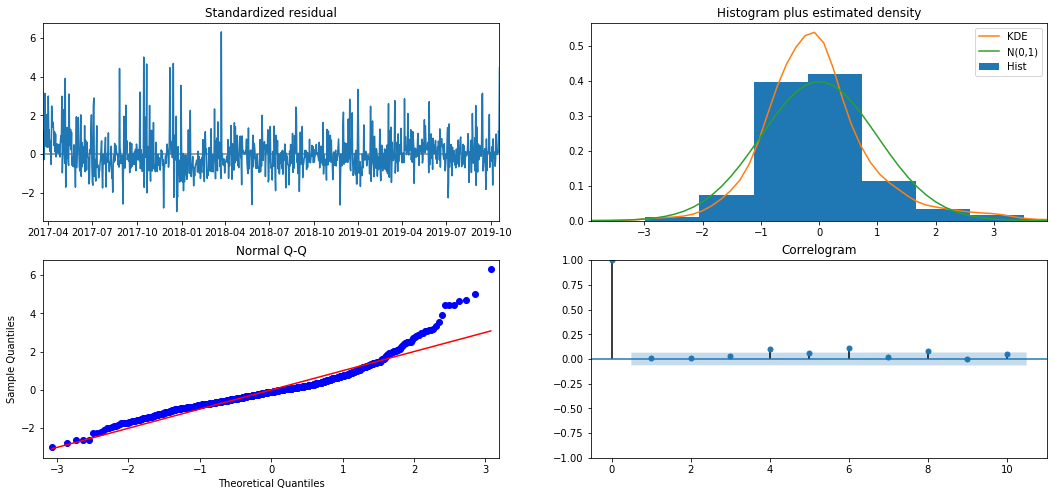

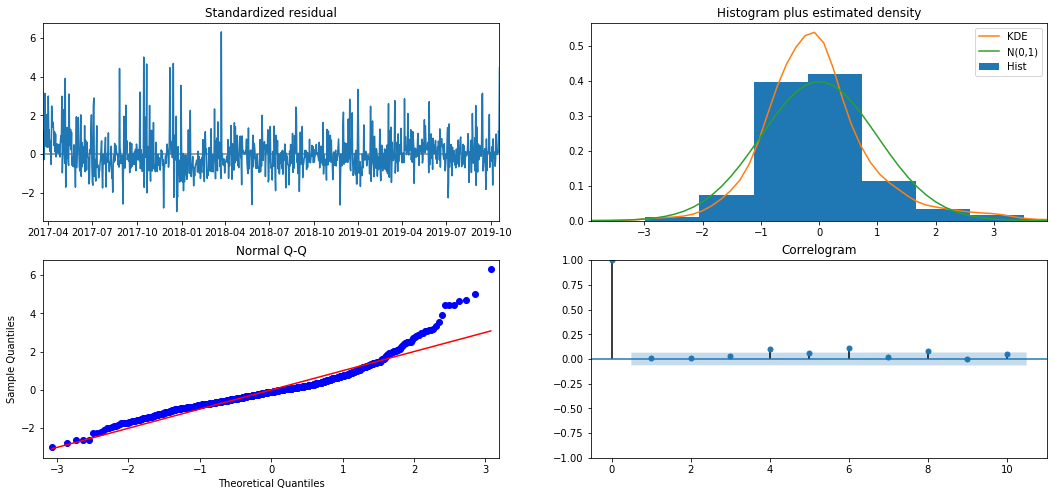

In [16]:
results.plot_diagnostics(figsize=(18, 8))

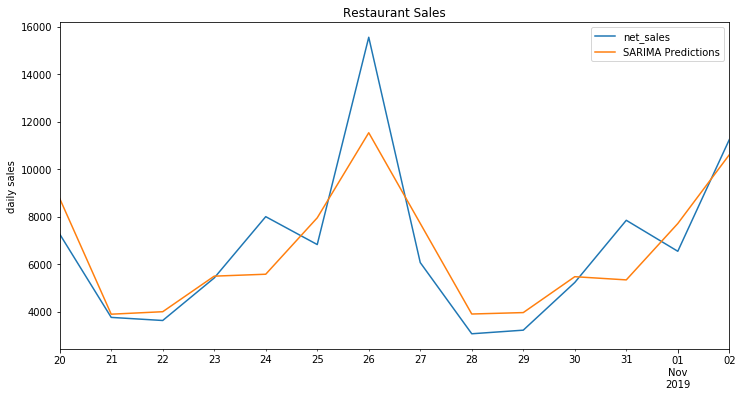

In [109]:
ax = test['net_sales'].plot(legend=True,figsize=(12,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel);

## Add exog data?

In [60]:
bdf.head()

,net_sales,day_of_week,AWND,PRCP,SNOW,SNWD,TAVG,TMAX,TMIN,WDF2,...,WSF5,WT01,WT02,WT03,WT04,WT05,WT06,WT08,WT09,is_holiday
DATE,,,,,,,,,,,,,,,,,,,,,
2017-03-14,5120.50,Tuesday,22.59,1.15,6.9,3.9,30.0,32,22,10,...,47.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0
2017-03-15,4105.00,Wednesday,19.24,0.00,0.0,5.1,24.0,27,20,270,...,40.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2017-03-16,6941.00,Thursday,15.21,0.00,0.0,5.1,30.0,41,23,290,...,33.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2017-03-17,15053.39,Friday,10.74,0.00,0.0,3.9,36.0,47,26,260,...,25.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2017-03-18,11338.50,Saturday,9.17,0.05,0.0,3.1,36.0,39,28,40,...,25.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [51]:
model = SARIMAX(train['net_sales'],exog=train['is_holiday'],order=(0,0,2),seasonal_order=(1,1,3,7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         net_sales   No. Observations:                  950
Model:             SARIMAX(0, 0, 2)x(1, 1, 3, 7)   Log Likelihood               -8341.491
Date:                           Wed, 13 Nov 2019   AIC                          16698.981
Time:                                   11:22:27   BIC                          16737.774
Sample:                               03-14-2017   HQIC                         16713.767
                                    - 10-19-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
is_holiday  1640.6415    342.433      4.791      0.000     969.486    2311.797
ma.L1          0.1703      0.029      5.880      0.000       0.114       0.227
ma.L2          0.0208      0.037      0.566      0.571      -0.051       0.093
ar.S.L7        0.9960      0.017     58.078      0.000       0.962       1.030
ma.S.L7       -1.7784      0.048    -37.062      0.000      -1.872      -1.684
ma.S.L14       0.6513      0.056     11.724      0.000       0.542       0.760
ma.S.L21       0.1271      0.023      5.596      0.000       0.083       0.172
sigma2      2.768e+06      0.001   5.25e+09      0.000    2.77e+06    2.77e+06
===================================================================================
Ljung-Box (Q):                       85.66   Jarque-Bera (JB):              1371.48
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             1.40
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.20
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.02e+27. Standard errors may be unstable.
"""

In [52]:
exog_forecast = bdf[950:][['is_holiday']]
exog_forecast.columns

Index(['is_holiday'], dtype='object')

In [53]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=True,exog=exog_forecast).rename('SARIMA Predictions with holidays')
 
mse_error = mean_squared_error(test['net_sales'], predictions)
rmse_error = rmse(test['net_sales'], predictions)
print(f'SARIMA MSE Error: {mse_error}')
print(f'SARIMA RMSE Error: {rmse_error}')

SARIMA MSE Error: 2725468.7551214998
SARIMA RMSE Error: 1650.8993776488921


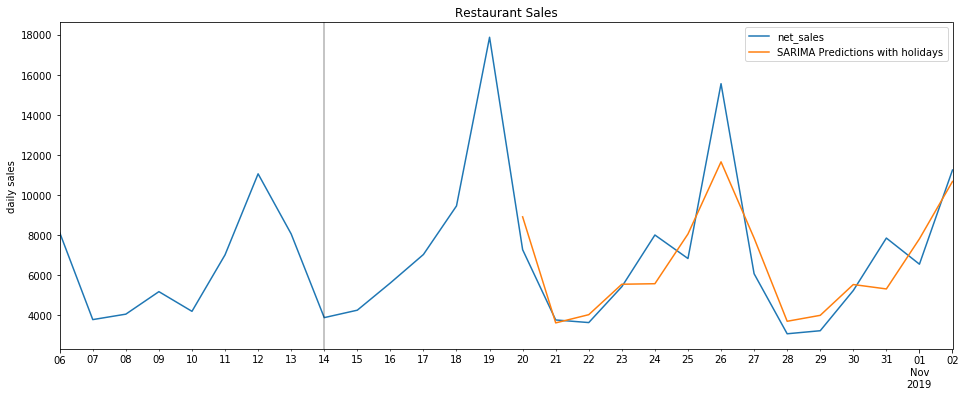

In [56]:
# Plot the forecast alongside historical values
title='Restaurant Sales'
ylabel='daily sales'
xlabel=''

ax = bdf['net_sales'][936:].plot(legend=True,figsize=(16,6),title=title)
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
for x in bdf[936:].query('is_holiday==1').index: 
    ax.axvline(x=x, color='k', alpha = 0.3);

## Retraining the model on all the data

In [57]:
model = SARIMAX(bdf['net_sales'],order=(0,0,2),seasonal_order=(1,1,3,7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         net_sales   No. Observations:                  964
Model:             SARIMAX(0, 0, 2)x(1, 1, 3, 7)   Log Likelihood               -8472.574
Date:                           Wed, 13 Nov 2019   AIC                          16959.148
Time:                                   11:34:06   BIC                          16993.195
Sample:                               03-14-2017   HQIC                         16972.116
                                    - 11-02-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1500      0.027      5.459      0.000       0.096       0.204
ma.L2          0.0043      0.035      0.124      0.901      -0.064       0.073
ar.S.L7       -0.9635      0.028    -35.022      0.000      -1.017      -0.910
ma.S.L7        0.1989      0.035      5.711      0.000       0.131       0.267
ma.S.L14      -0.8600      0.031    -27.726      0.000      -0.921      -0.799
ma.S.L21      -0.1519      0.022     -6.770      0.000      -0.196      -0.108
sigma2      2.807e+06   7.66e+04     36.657      0.000    2.66e+06    2.96e+06
===================================================================================
Ljung-Box (Q):                       83.05   Jarque-Bera (JB):              1162.63
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.57   Skew:                             1.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [58]:
predictions = results.predict(start=start, end=end, dynamic=True).rename('SARIMA Predictions')

In [59]:
mse_error = mean_squared_error(bdf['net_sales'], predictions)
rmse_error = rmse(bdf['net_sales'], predictions)
print(f'SARIMA MSE Error: {mse_error}')
print(f'SARIMA RMSE Error: {rmse_error}')

ValueError: Found input variables with inconsistent numbers of samples: [964, 14]

# HERE I REALLY DO ADD ALL THE EXOG DATA

In [66]:
train.columns

Index(['net_sales', 'day_of_week', 'AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG',
       'TMAX', 'TMIN', 'WDF2', 'WDF5', 'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03',
       'WT04', 'WT05', 'WT06', 'WT08', 'WT09', 'is_holiday'],
      dtype='object')

In [134]:
w_train = w_df.iloc[:950]

In [135]:
w_train['AWND'].fillna(bdf['AWND'].mean(), inplace=True)

In [140]:
model = SARIMAX(train['net_sales'],exog=w_train,order=(0,0,2),seasonal_order=(1,1,3,7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         net_sales   No. Observations:                  950
Model:             SARIMAX(0, 0, 2)x(1, 1, 3, 7)   Log Likelihood               -8373.545
Date:                           Wed, 13 Nov 2019   AIC                          16801.090
Time:                                   16:14:10   BIC                          16932.015
Sample:                               03-14-2017   HQIC                         16850.992
                                    - 10-19-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AWND          20.0486     54.820      0.366      0.715     -87.397     127.494
PRCP        -232.8122    304.339     -0.765      0.444    -829.306     363.681
SNOW         215.7452    175.585      1.229      0.219    -128.396     559.886
SNWD          -2.9520    159.102     -0.019      0.985    -314.786     308.882
TAVG           8.4525     46.380      0.182      0.855     -82.451      99.356
TMAX          23.0921     25.999      0.888      0.374     -27.866      74.050
TMIN         -22.4285     29.759     -0.754      0.451     -80.754      35.897
WDF2           1.1534      1.513      0.762      0.446      -1.813       4.120
WDF5          -0.6443      1.686     -0.382      0.702      -3.950       2.661
WSF2          -1.4558     58.248     -0.025      0.980    -115.620     112.708
WSF5         -16.6897     49.980     -0.334      0.738    -114.649      81.270
WT01        -101.6113    247.205     -0.411      0.681    -586.125     382.902
WT02          64.0955    722.190      0.089      0.929   -1351.371    1479.562
WT03         -57.9677    356.122     -0.163      0.871    -755.954     640.018
WT04       -1036.2935   1172.575     -0.884      0.377   -3334.498    1261.911
WT05         301.9602   1696.804      0.178      0.859   -3023.714    3627.634
WT06        -628.6216   2513.169     -0.250      0.802   -5554.342    4297.099
WT08         230.7363    426.609      0.541      0.589    -605.403    1066.875
WT09        -131.4942   3129.868     -0.042      0.966   -6265.922    6002.934
is_holiday          0   1.45e+05          0      1.000   -2.85e+05    2.85e+05
ma.L1          0.1485      0.046      3.253      0.001       0.059       0.238
ma.L2         -0.0039      0.057     -0.067      0.946      -0.116       0.108
ar.S.L7        0.0009      0.398      0.002      0.998      -0.779       0.780
ma.S.L7       -0.7650      0.397     -1.926      0.054      -1.543       0.013
ma.S.L14      -0.0325      0.303     -0.108      0.914      -0.625       0.560
ma.S.L21      -0.1226      0.071     -1.719      0.086      -0.262       0.017
sigma2      4.296e+06   1.93e+05     22.278      0.000    3.92e+06    4.67e+06
===================================================================================
Ljung-Box (Q):                       62.02   Jarque-Bera (JB):              1319.59
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):               0.58   Skew:                             1.36
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.12
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.86e+14. Standard errors may be unstable.
"""

In [141]:
exog_forecast = w_df[950:]
exog_forecast.columns

Index(['AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WDF5',
       'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT08',
       'WT09', 'is_holiday'],
      dtype='object')

In [142]:
exog_forecast['TAVG'].fillna(exog_forecast['TAVG'].mean(), inplace=True)

In [144]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=True,exog=exog_forecast).rename('SARIMA Predictions with all EXOG data')
 
mse_error = mean_squared_error(test['net_sales'], predictions)
rmse_error = rmse(test['net_sales'], predictions)
print(f'SARIMA MSE Error: {mse_error}')
print(f'SARIMA RMSE Error: {rmse_error}')

SARIMA MSE Error: 2452451.151548849
SARIMA RMSE Error: 1566.0303801487535


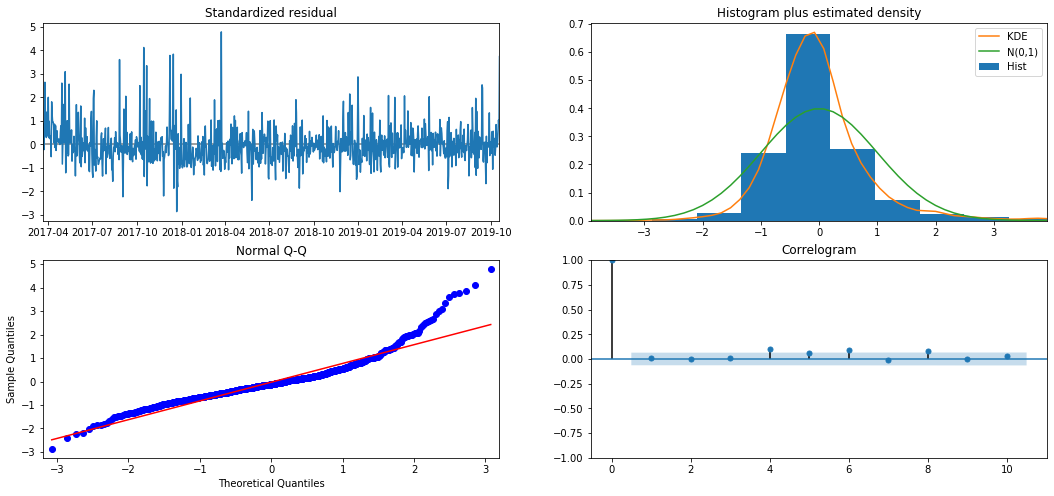

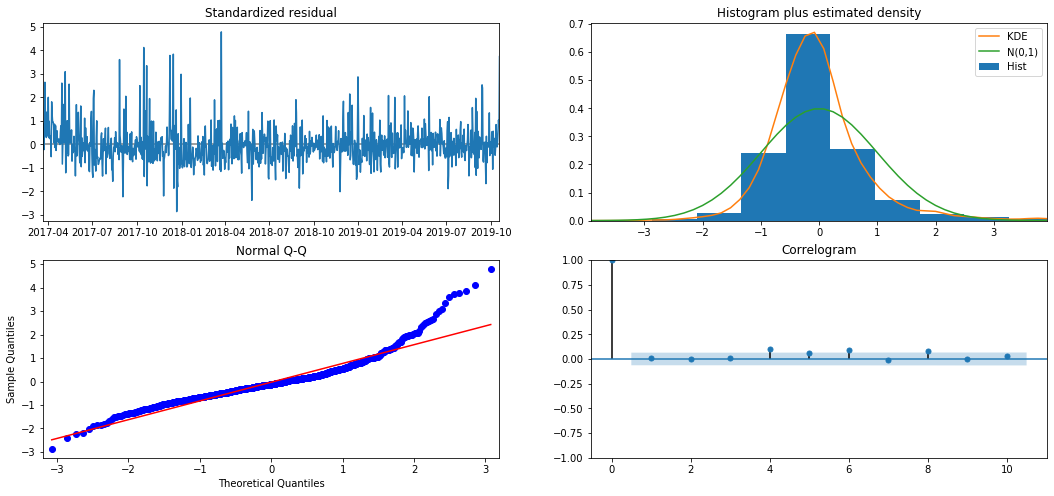

In [125]:
results.plot_diagnostics(figsize=(18, 8))

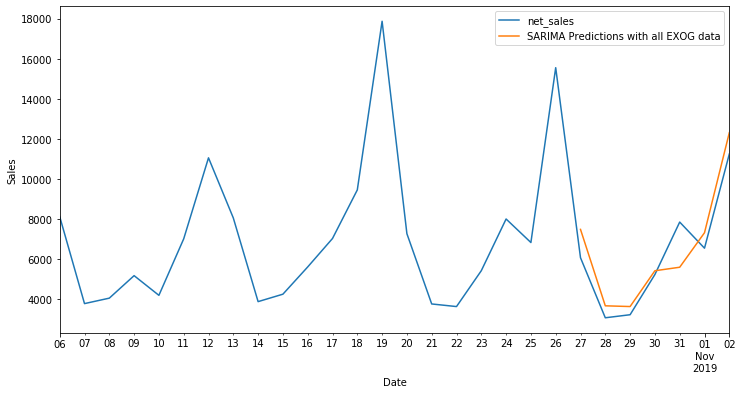

In [31]:
ax = bdf['net_sales'][936:].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel='Date', ylabel='Sales');

# Do previous model but predicting 7 days.

In [146]:
len(bdf)

964

In [15]:
# going to predict 7 days
train = bdf.iloc[:957]
test = bdf.iloc[957:]

In [16]:
w_train = w_df.iloc[:957]
w_train['AWND'].fillna(bdf['AWND'].mean(), inplace=True)

In [18]:
w_train['TAVG'].fillna(bdf['TAVG'].mean(), inplace=True)

In [19]:
model = SARIMAX(train['net_sales'],exog=w_train,order=(0,0,2),seasonal_order=(1,1,3,7))
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                         net_sales   No. Observations:                  957
Model:             SARIMAX(0, 0, 2)x(1, 1, 3, 7)   Log Likelihood               -8435.493
Date:                           Wed, 13 Nov 2019   AIC                          16924.986
Time:                                   16:45:30   BIC                          17056.110
Sample:                               03-14-2017   HQIC                         16974.946
                                    - 10-26-2019                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
AWND          20.8358     54.689      0.381      0.703     -86.352     128.023
PRCP        -222.3299    303.707     -0.732      0.464    -817.584     372.924
SNOW         215.0179    173.667      1.238      0.216    -125.362     555.398
SNWD          -4.2011    153.186     -0.027      0.978    -304.440     296.038
TAVG           6.8618     46.122      0.149      0.882     -83.535      97.258
TMAX          24.5365     26.226      0.936      0.349     -26.866      75.939
TMIN         -20.8876     29.525     -0.707      0.479     -78.756      36.980
WDF2           0.6638      1.496      0.444      0.657      -2.269       3.597
WDF5          -0.2579      1.666     -0.155      0.877      -3.524       3.008
WSF2          -2.2798     57.934     -0.039      0.969    -115.828     111.269
WSF5         -16.0811     49.578     -0.324      0.746    -113.252      81.090
WT01        -105.5204    243.353     -0.434      0.665    -582.483     371.443
WT02          66.8976    717.545      0.093      0.926   -1339.466    1473.261
WT03         -60.6503    355.098     -0.171      0.864    -756.630     635.329
WT04       -1040.2377   1164.289     -0.893      0.372   -3322.203    1241.727
WT05         300.8682   1723.551      0.175      0.861   -3077.231    3678.967
WT06        -622.9089   2520.016     -0.247      0.805   -5562.050    4316.232
WT08         231.7057    428.628      0.541      0.589    -608.389    1071.800
WT09        -144.7613   3191.189     -0.045      0.964   -6399.378    6109.855
is_holiday          0   1.78e+05          0      1.000   -3.49e+05    3.49e+05
ma.L1          0.1361      0.044      3.058      0.002       0.049       0.223
ma.L2         -0.0059      0.056     -0.104      0.917      -0.116       0.105
ar.S.L7        0.1636      0.384      0.426      0.670      -0.590       0.917
ma.S.L7       -0.9169      0.384     -2.391      0.017      -1.669      -0.165
ma.S.L14       0.0775      0.286      0.271      0.786      -0.483       0.638
ma.S.L21      -0.0989      0.078     -1.263      0.206      -0.252       0.055
sigma2      4.276e+06   1.95e+05     21.882      0.000    3.89e+06    4.66e+06
===================================================================================
Ljung-Box (Q):                       61.35   Jarque-Bera (JB):              1290.58
Prob(Q):                              0.02   Prob(JB):                         0.00
Heteroskedasticity (H):               0.59   Skew:                             1.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.38e+14. Standard errors may be unstable.
"""

In [20]:
exog_forecast = w_df[957:]
exog_forecast.columns

Index(['AWND', 'PRCP', 'SNOW', 'SNWD', 'TAVG', 'TMAX', 'TMIN', 'WDF2', 'WDF5',
       'WSF2', 'WSF5', 'WT01', 'WT02', 'WT03', 'WT04', 'WT05', 'WT06', 'WT08',
       'WT09', 'is_holiday'],
      dtype='object')

In [21]:
exog_forecast['TAVG'].fillna(exog_forecast['TAVG'].mean(), inplace=True)

In [22]:
start=len(train)
end=len(train)+len(test)-1
predictions = results.predict(start=start, end=end, dynamic=False,exog=exog_forecast).rename('SARIMA Predictions with all EXOG data')
 
mse_error = mean_squared_error(test['net_sales'], predictions)
rmse_error = rmse(test['net_sales'], predictions)
print(f'SARIMA MSE Error: {mse_error}')
print(f'SARIMA RMSE Error: {rmse_error}')

SARIMA MSE Error: 1339927.2457902597
SARIMA RMSE Error: 1157.5522648201504


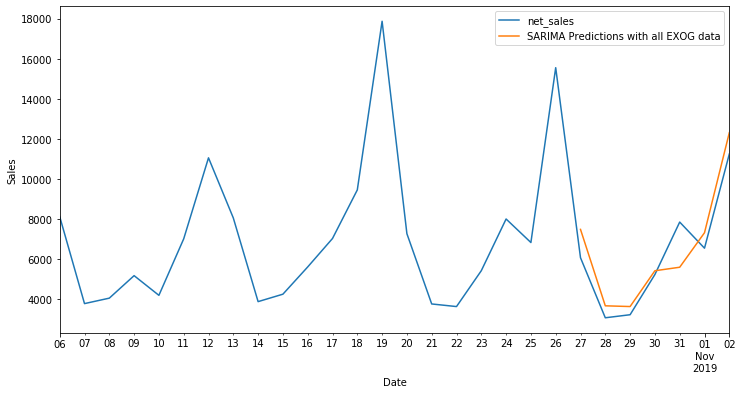

In [28]:
ax = bdf['net_sales'][936:].plot(legend=True,figsize=(12,6))
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel='Date', ylabel='Sales');

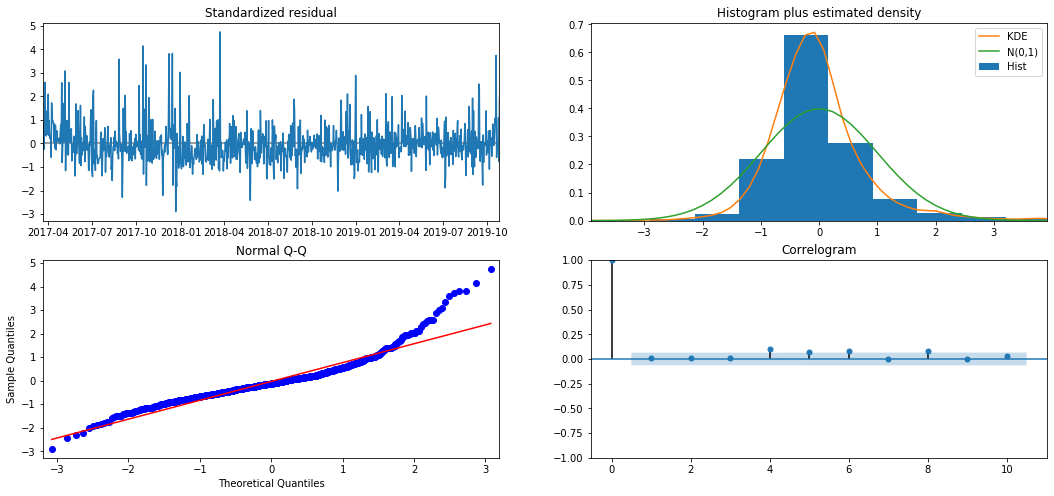

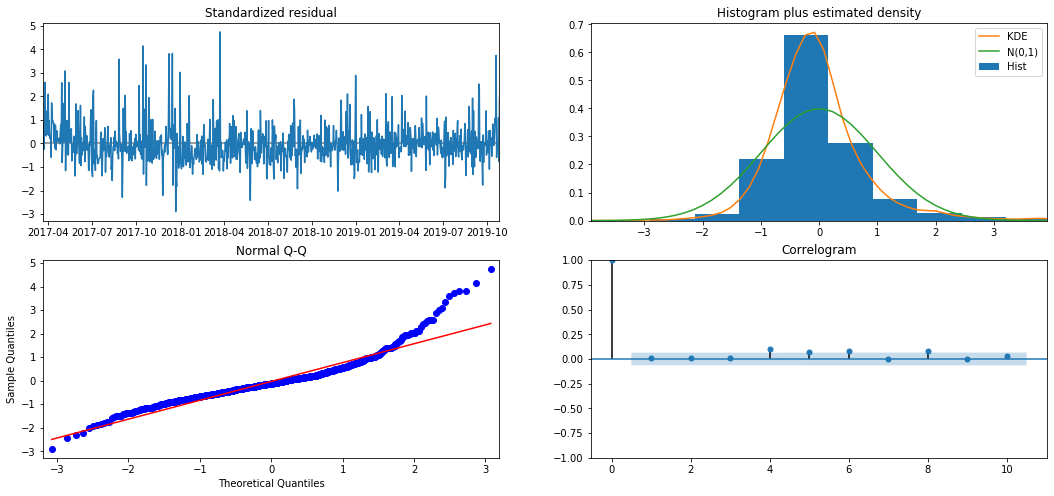

In [27]:
results.plot_diagnostics(figsize=(18, 8))